In [1]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import os

# Kiểm tra các file trong thư mục
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Dependencies


In [2]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings

warnings.filterwarnings("ignore")
from sklearn.metrics import classification_report
import tensorflow as tf
import itertools
from tensorflow.keras import layers, regularizers, Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Conv2D, Dropout


2024-10-13 23:39:12.141778: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-13 23:39:12.144077: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-13 23:39:12.173942: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-13 23:39:12.173968: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-13 23:39:12.174793: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [3]:
train_path = "train"
folds = os.listdir(train_path)
file = []
label = []
for fold in folds:
    file_path = os.path.join(train_path, fold)
    images = os.listdir(file_path)

    for image in images:
        file.append(os.path.join(file_path, image))
        label.append(fold)


files = pd.Series(file)
labels = pd.Series(label)

results = pd.concat([files, labels], axis=1)
train_df = pd.DataFrame(results)
train_df.columns = ["file", "label"]

In [4]:
test_path = "test"
folder = os.listdir(test_path)
file = []
label = []
folds = os.listdir(test_path)
for fold in folds:
    file_path = os.path.join(test_path, fold)
    images = os.listdir(file_path)

    for image in images:
        file.append(os.path.join(file_path, image))
        label.append(fold)


files = pd.Series(file)
labels = pd.Series(label)

results = pd.concat([files, labels], axis=1)
test_df = pd.DataFrame(results)
test_df.columns = ["file", "label"]

In [5]:
valid, test_df = train_test_split(test_df, test_size=0.5, shuffle=True, random_state=42)

ValueError: With n_samples=0, test_size=0.5 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
image_size = (224, 224)
batch_size = 16

# Default colour as RGB
training_generator = ImageDataGenerator()

train_generated = training_generator.flow_from_dataframe(
    train_df,
    x_col="file",
    y_col="label",
    target_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical",
)

valid_generated = training_generator.flow_from_dataframe(
    valid,
    x_col="file",
    y_col="label",
    target_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode="categorical",
)
test_generated = training_generator.flow_from_dataframe(
    test_df,
    x_col="file",
    y_col="label",
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)

Found 282 validated image filenames belonging to 5 classes.


Found 12 validated image filenames belonging to 5 classes.
Found 13 validated image filenames belonging to 5 classes.


# Let's see the data for curiosity


In [ ]:
label_dict = train_generated.class_indices
classes = list(label_dict.keys())
images, labels = next(
    train_generated
)  # Creating vector form of image and mapping it with labels using next

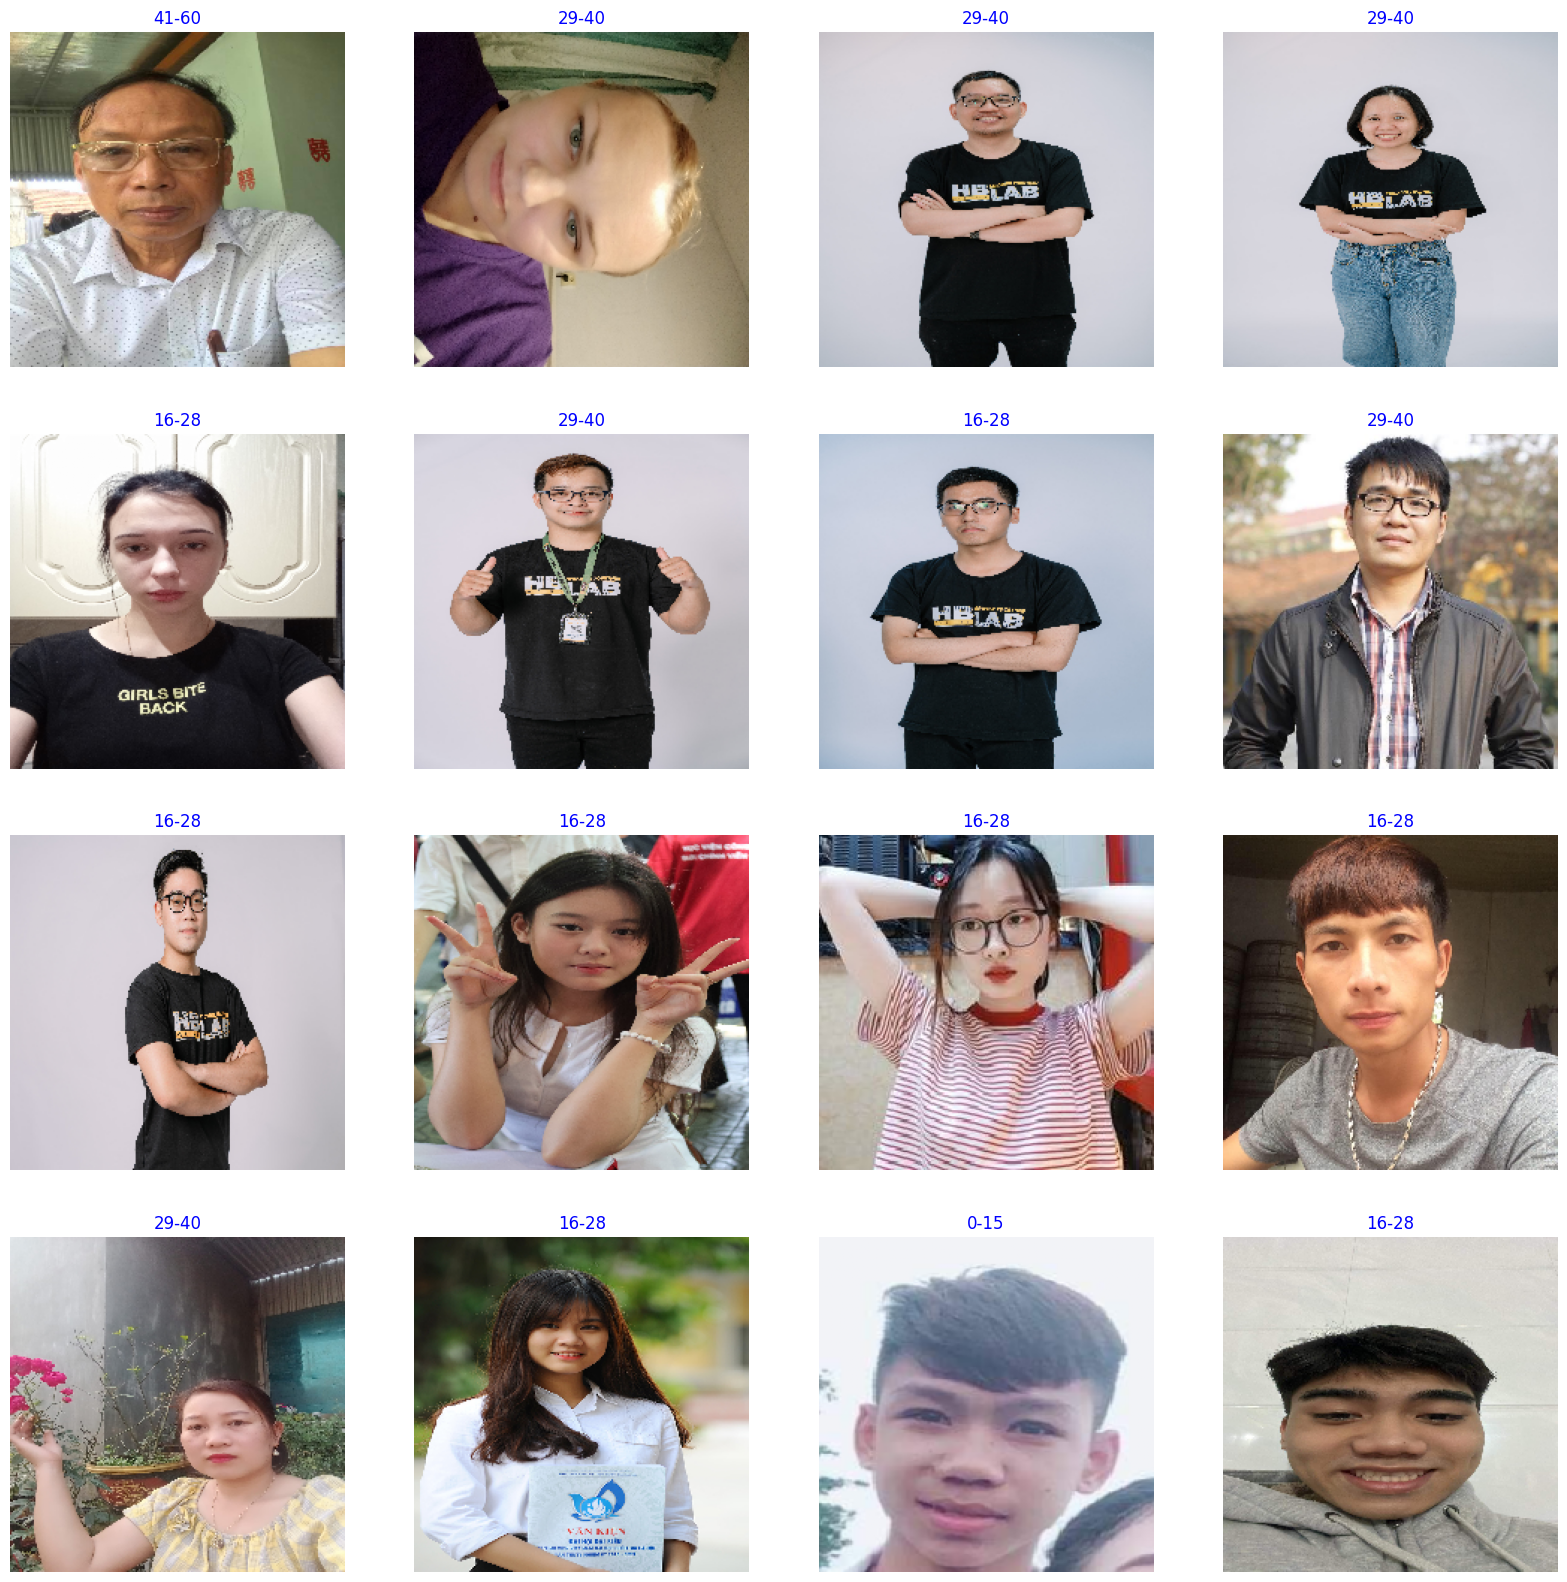

In [ ]:
plt.figure(figsize=(20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color="blue", fontsize=12)
    plt.axis("off")
plt.show()

# Creating the model


In [ ]:
input_shape = (224, 224, 3)
num_of_classes = len(classes)

img_height = 180
img_width = 180
input_shape = (img_height, img_width, 3)
num_of_classes = 5  # Thay đổi theo số lượng lớp của bạn

data_augmentation = Sequential(
[
    # Lật ảnh theo chiều ngang
    layers.RandomFlip("horizontal", input_shape=input_shape),
    # Quay ảnh trong khoảng từ 0 đến 0.1 radians
    layers.RandomRotation(0.1),
    # Zoom ảnh trong khoảng từ 0 đến 0.1
    layers.RandomZoom(0.1),
]
)

base_model = tf.keras.applications.EfficientNetB3(
    include_top=False, weights="imagenet", input_shape=input_shape, pooling="max"
)

model = Sequential(
    [
        data_augmentation,
        base_model,
        BatchNormalization(),
        Dense(
            512,
            kernel_regularizer=regularizers.l2(l=0.016),
            activity_regularizer=regularizers.l1(l=0.006),
            bias_regularizer=regularizers.l1(0.006),
            activation="relu",
        ),
        Dropout(0.4),
        Dense(
            256,
            kernel_regularizer=regularizers.l2(l=0.016),
            activity_regularizer=regularizers.l2(l=0.006),
            bias_regularizer=regularizers.l1(0.006),
            activation="relu",
        ),
        Dropout(0.4),
        Dense(num_of_classes, activation="softmax"),
    ]
)

optimizer = tf.keras.optimizers.Adamax(learning_rate=0.001)
loss = "categorical_crossentropy"

model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

# Ceratinly you can go with more higher model if you have extra GPU's and can also increase number of epochs while training which definately will increase your accuracy and must try to implemet with different architecture


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 512)               786944    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)              

In [ ]:
history = model.fit(
    x=train_generated,
    epochs=50,
    verbose=2,
    validation_data=valid_generated,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=10, restore_best_weights=True
        ),
        tf.keras.callbacks.ModelCheckpoint(
            filepath="best_model.h5", monitor="val_loss", save_best_only=True
        ),
        tf.keras.callbacks.TensorBoard(log_dir="logs", histogram_freq=1),
    ],
)

Epoch 1/50
18/18 - 105s - loss: 21.7600 - accuracy: 0.3050 - val_loss: 22.6139 - val_accuracy: 0.1667 - 105s/epoch - 6s/step
Epoch 2/50
18/18 - 87s - loss: 20.1743 - accuracy: 0.3936 - val_loss: 20.5587 - val_accuracy: 0.3333 - 87s/epoch - 5s/step
Epoch 3/50
18/18 - 91s - loss: 19.1622 - accuracy: 0.5496 - val_loss: 19.5665 - val_accuracy: 0.3333 - 91s/epoch - 5s/step
Epoch 4/50
18/18 - 81s - loss: 18.3622 - accuracy: 0.6099 - val_loss: 19.0123 - val_accuracy: 0.2500 - 81s/epoch - 4s/step
Epoch 5/50
18/18 - 65s - loss: 17.6506 - accuracy: 0.6348 - val_loss: 18.4741 - val_accuracy: 0.2500 - 65s/epoch - 4s/step
Epoch 6/50
18/18 - 61s - loss: 16.9544 - accuracy: 0.6844 - val_loss: 17.9753 - val_accuracy: 0.2500 - 61s/epoch - 3s/step
Epoch 7/50
18/18 - 60s - loss: 16.2040 - accuracy: 0.7624 - val_loss: 17.3828 - val_accuracy: 0.2500 - 60s/epoch - 3s/step
Epoch 8/50
18/18 - 61s - loss: 15.6196 - accuracy: 0.7447 - val_loss: 16.7549 - val_accuracy: 0.2500 - 61s/epoch - 3s/step
Epoch 9/50
18/

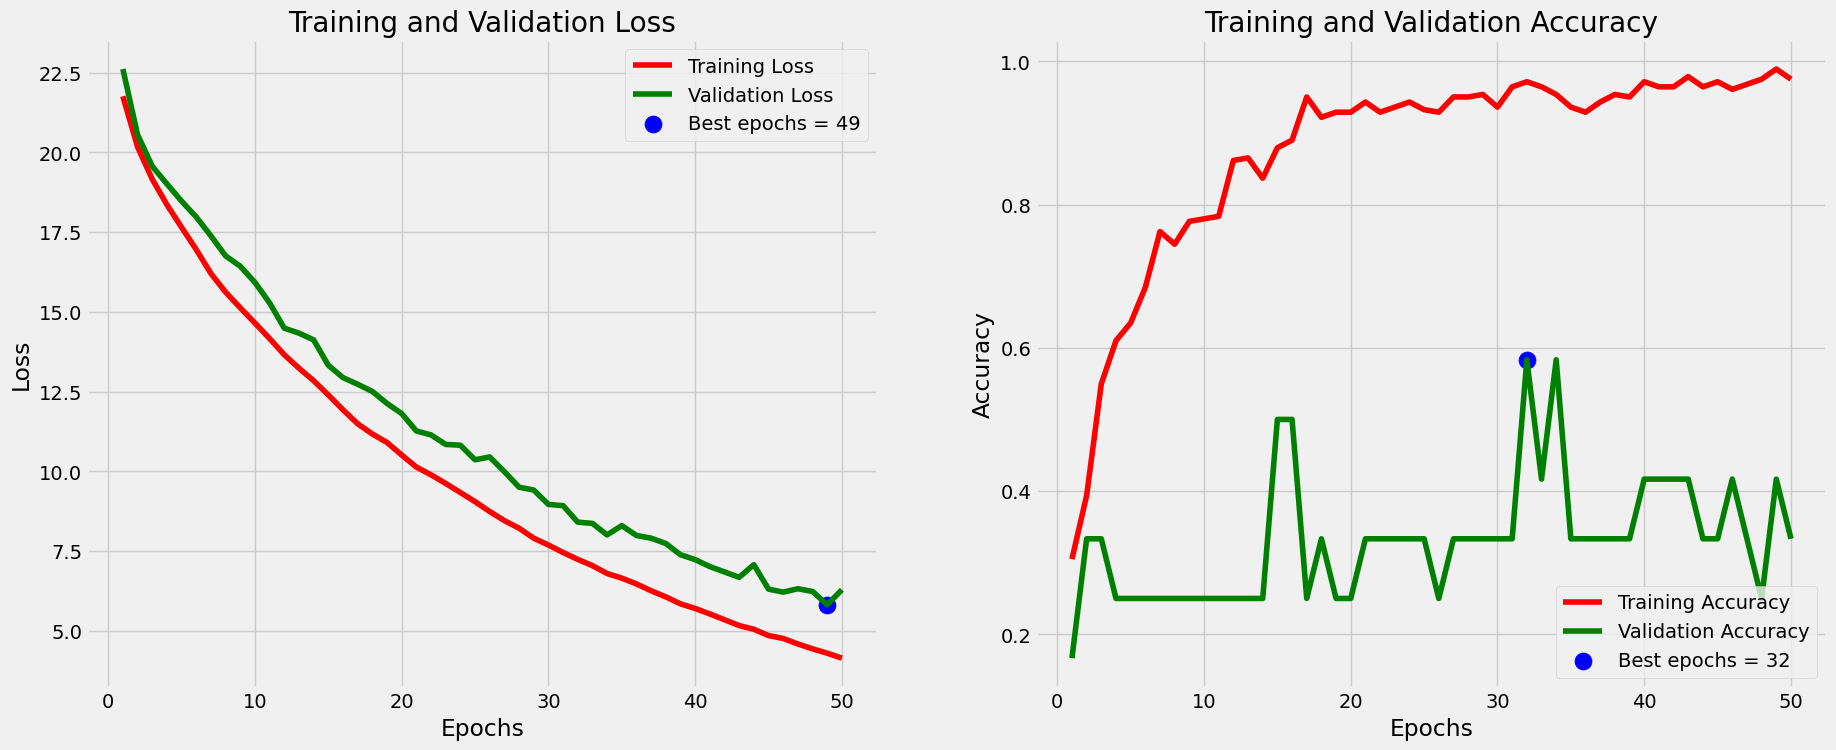

In [ ]:
train_acc = history.history["accuracy"]
train_loss = history.history["loss"]

val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i + 1 for i in range(len(train_acc))]

loss_label = f"Best epochs = {str(index_loss +1)}"
acc_label = f"Best epochs = {str(index_acc + 1)}"

# Training history

plt.figure(figsize=(20, 8))
plt.style.use("fivethirtyeight")

plt.subplot(1, 2, 1)
plt.plot(Epochs, train_loss, "r", label="Training Loss")
plt.plot(Epochs, val_loss, "g", label="Validation Loss")
plt.scatter(index_loss + 1, val_lowest, s=150, c="blue", label=loss_label)
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, train_acc, "r", label="Training Accuracy")
plt.plot(Epochs, val_acc, "g", label="Validation Accuracy")
plt.scatter(index_acc + 1, val_highest, s=150, c="blue", label=acc_label)
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout
plt.show()

# Evaluating the model


In [ ]:
train_score = model.evaluate(train_generated, steps=16, verbose=1)
valid_score = model.evaluate(valid_generated, steps=16, verbose=1)
test_score = model.evaluate(test_generated, steps=16, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print("-" * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print("-" * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 [==============================] - 1s 2ms/step - loss: 6.5607 - accuracy: 0.2308
Train Loss:  4.001554012298584
Train Accuracy:  0.9921875
--------------------
Validation Loss:  6.287445545196533
Validation Accuracy:  0.3333333432674408
--------------------
Test Loss:  6.5606913566589355
Test Accuracy:  0.23076923191547394


In [ ]:
test_path='mytest'
file=[]
images=os.listdir(test_path)
for image in images:
    file.append(os.path.join(test_path,image))
        
files=pd.Series(file)
mytest_df = pd.DataFrame(files, columns=['file'])

mytest=training_generator.flow_from_dataframe(mytest_df,x_col='file',y_col=None,target_size=image_size,
                                                      batch_size=batch_size,shuffle=False,class_mode=None)

preds = model.predict_generator(mytest)
age_labels = ["0-15", "16-28", "29-40", "41-60", "60-100"]
y_pred = np.argmax(preds,axis=1)
for i, pred in enumerate(y_pred):
    print(f"Ảnh {mytest_df['file'][i]} dự đoán độ tuổi: {age_labels[pred]}")

Found 5 validated image filenames.
Ảnh mytest/6.jpg dự đoán độ tuổi: 60-100
Ảnh mytest/3.jpg dự đoán độ tuổi: 60-100
Ảnh mytest/4.jpg dự đoán độ tuổi: 0-15
Ảnh mytest/1.jpg dự đoán độ tuổi: 16-28
Ảnh mytest/2.jpg dự đoán độ tuổi: 16-28
